# Clusterización

 Utilizando el set de datos que hayas utilizado en las prácticas anteriores, aplica el modelo K-Means para realizar una agrupación de la data, posteriormente realiza análisis sobre los resultados.

- Elige Set de Datos (Opiniones)

In [2]:
import pandas as pd
# Cargar el archivo Excel
file_path = 'corpus/Rest_Mex_2022_Sentiment_Analysis_Track_Train.xlsx'
df = pd.read_excel(file_path)
df.head()

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1,Hotel
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1,Hotel
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1,Hotel


**Preprocesa el set de datos: Aplicación de técnicas de Normalización (minúsculas, tokenización, eliminación de stopwords)**
- Funcion para preprocesamiento del texto

In [3]:
# Bibliotecas para procesamiento de texto
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Eliminamos valores nulos
df = df.dropna()
# Lematizador
lemmatizer = WordNetLemmatizer()
# Stopwords en español
stop_words = set(stopwords.words('spanish'))
# Creamos lista de tags a utilizar
tags = ['ADJ', 'NOUN', 'VERB']
# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

def normalize_text(text):
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Convertir a minúsculas
    tokens_lower = [word.lower() for word in tokens]
    # Eliminar puntuación
    tokens_no_punct = [word for word in tokens_lower if word.isalnum()]
    # Eliminar stopwords
    tokens_no_stopwords = [word for word in tokens_no_punct if word not in stop_words]
    # Unir tokens
    tokens = " ".join(tokens_no_stopwords)
    # Procesar texto con spaCy
    doc = nlp(tokens)
    # Discriminar por tags
    normalized_text = [word.lemma_ for word in doc if word.pos_ in tags]
    # normalized_text = [word.lemma_ for word in doc]
    # Unir en una sola cadena
    normalized_text = " ".join(normalized_text)

    return normalized_text

#sample_sentence = "¡Hola, Juan! ¿Cómo estás? Él está viajando en un avión a París. ¡Qué emocionante! #vacaciones"
#normalize_text(sample_sentence)


- Preprocesamiento del texto en paralelo

In [4]:
from concurrent.futures import ThreadPoolExecutor

def parallel_processing_threads(data, func):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(func, data))
    return results

# Normaliza el dataframe en paralelo
df['Opinion'] = parallel_processing_threads(df['Opinion'], normalize_text)

# Mostrar el dataframe
df.head()

# Guardar el dataframe en un archivo CSV
df.to_csv('corpus/Rest_Mex_2022_Sentiment_Analysis_Track_Train_Normalized.csv', index=False)

**Vectoriza el dataset con Red Neuronal Doc2Vec**

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Preparar los datos
tagged_data = [TaggedDocument(words=opinion.split(), tags=[str(i)]) for i, opinion in enumerate(df['Opinion'])]

# Construir y entrenar el modelo
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Guardar el modelo para uso futuro
model.save("doc2vec_model_cluster")

**Cargar el modelo**

In [6]:
from gensim.models.doc2vec import Doc2Vec
import numpy as np

# Cargar el dataframe normalizado
df = pd.read_csv('corpus/Rest_Mex_2022_Sentiment_Analysis_Track_Train_Normalized.csv')

# Cargar el modelo
model = Doc2Vec.load("doc2vec_model_cluster")

# Preparar los datos
vector_op = np.array([model.infer_vector(opinion.split()) for opinion in df['Opinion']])

# Dimensiones del vector
vector_op.shape

(30208, 20)

**Crear nuevo Dataframe con el vector**

In [7]:
df_vector = pd.DataFrame(vector_op)

# Eliminar valores nulos
df_vector = df_vector.dropna()

# Nombrar columnas
df_vector.columns = ['V' + str(i) for i in range(20)]

# Mostrar el dataframe
df_vector.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
0,3.370344,0.251480,-1.842438,1.162277,1.650606,0.164609,0.345080,1.252882,-1.911658,1.998778,1.767083,2.158906,-0.122983,-1.686529,-0.340792,0.622609,0.243362,1.665942,-1.230183,0.005473
1,1.949443,-4.776636,-0.585707,-1.624254,2.805977,-0.932227,1.140362,0.146642,-2.289949,-1.642941,2.389095,1.254764,-1.076670,-1.498457,0.182509,0.795250,0.998276,-2.494186,-0.514808,-0.776054
2,0.550260,-1.352988,0.011577,-2.508907,-0.251137,-1.248390,3.246693,2.077363,-0.380698,-0.139107,-1.771817,-1.058986,0.704488,0.048660,-0.180307,0.480885,1.117527,-0.803038,-2.592032,-3.017796
3,-0.097348,-3.395986,-3.488587,-1.736962,-0.617732,2.283769,1.523119,1.417278,-3.427533,3.303368,-0.306467,1.512276,-2.492620,0.762560,-2.222413,0.757071,-0.435496,0.595144,-1.191843,-3.437004
4,3.022655,1.836640,0.035249,-1.585827,0.517936,1.299016,-0.259311,-0.383892,-2.205132,-0.091033,1.523813,2.153729,-1.510628,-2.636773,1.553101,0.008123,1.112094,1.890342,-0.357585,-1.591726


**Determina el número recomendado de clústers**

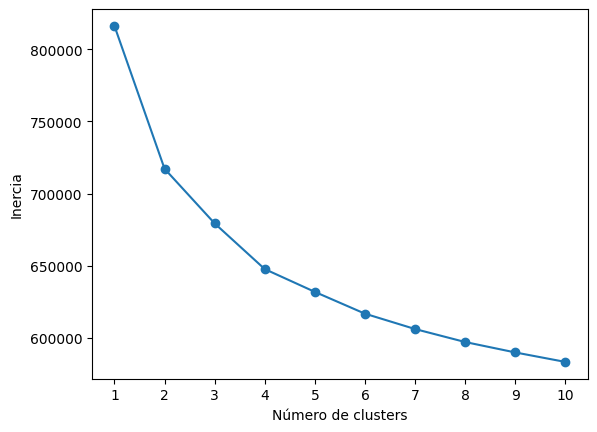

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Lista para almacenar los valores de la inercia
inertia = []

# Lista para almacenar el número de clusters
k = []

# Iterar de 1 a 10 clusters

for i in range(1, 11):
    # Crear el modelo
    model = KMeans(n_clusters=i, random_state=42, n_init=10)
    # Entrenar el modelo
    model.fit(df_vector)
    # Almacenar el valor de la inercia
    inertia.append(model.inertia_)
    # Almacenar el número de clusters
    k.append(i)

# Graficar el método del codo
plt.plot(k, inertia, '-o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.xticks(k)
plt.show()


**Entrenar Modelo K-means**

In [9]:
# Prepapar los datos
X = df_vector

# Crear el modelo
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Entrenar el modelo
kmeans.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=42)

**Evaluamos el modelo con metricas de Silueta y Calinski harabasz**

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

# Almacenar las etiquetas
ymeans = kmeans.labels_

print("El índice de silueta es: ", silhouette_score(X, ymeans))
print("La puntuación de Calinski-Harabasz es: ", calinski_harabasz_score(X, ymeans))

El índice de silueta es:  0.08934159
La puntuación de Calinski-Harabasz es:  3040.8043208165573


**Utiliza un tensor para reducir la dimensionalidad de los vectores**

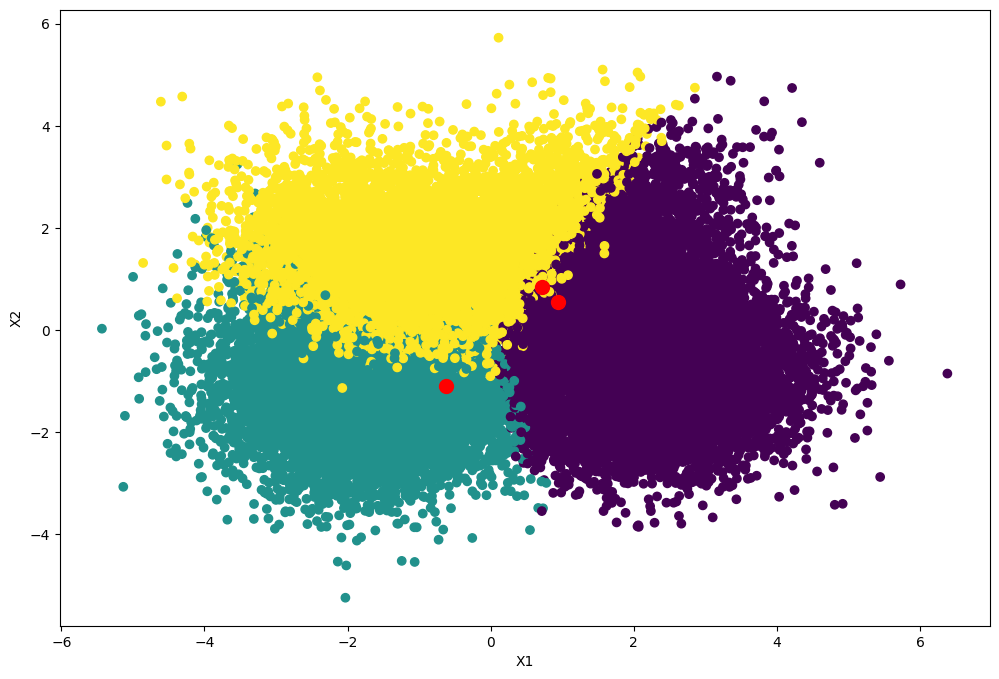

In [11]:
from sklearn.decomposition import PCA

# Crear el modelo
pca = PCA(n_components=2)

# Entrenar el modelo
pca.fit(X)

# Transformar los datos
X_pca = pca.transform(X)

# Graficar los clusters con centroides y con nombre de los clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Optimizacion de parametros para mejorar resultados

**Aplicamos Standar scaler a los datos**

In [12]:
# Aplicamos standard scaler
from sklearn.preprocessing import StandardScaler

# Preparar los datos
X = df_vector

# Crear el modelo
scaler = StandardScaler()

# Entrenar el modelo
scaler.fit(X)

# Transformar los datos
X_scaled = scaler.transform(X)

# Visualizamos los datos como dataframe
df_scaled = pd.DataFrame(X_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2.332596,0.170785,-1.533014,0.512960,1.704730,0.040518,0.156772,0.480443,-1.116344,1.701837,0.978677,1.506673,0.295118,-1.545041,-0.706867,0.100862,-1.229783,1.443601,-0.658038,0.854578
1,1.261606,-3.256728,-0.512421,-1.822008,2.743140,-0.915251,0.885662,-0.601548,-1.498162,-1.429279,1.569105,0.810152,-0.512122,-1.373907,-0.202489,0.240989,-0.487212,-1.850400,-0.026134,0.121400
2,0.206986,-0.922932,-0.027366,-2.563302,-0.004494,-1.190751,2.816152,1.286851,0.428888,-0.136296,-2.380532,-0.972281,0.995524,0.033875,-0.552186,-0.014169,-0.369911,-0.511344,-1.860985,-1.981659
3,-0.281141,-2.315581,-2.869853,-1.916452,-0.333978,1.887128,1.236466,0.641235,-2.646351,2.823512,-0.989586,1.008531,-1.710641,0.683481,-2.520445,0.210000,-1.897541,0.595740,-0.624171,-2.374933
4,2.070529,1.251340,-0.008142,-1.789808,0.686723,1.029027,-0.397163,-1.120453,-1.412554,-0.094963,0.747759,1.502684,-0.879442,-2.409704,1.118539,-0.397891,-0.375256,1.621282,0.112744,-0.643812


**Seleccion de caracteristicas con random forest**

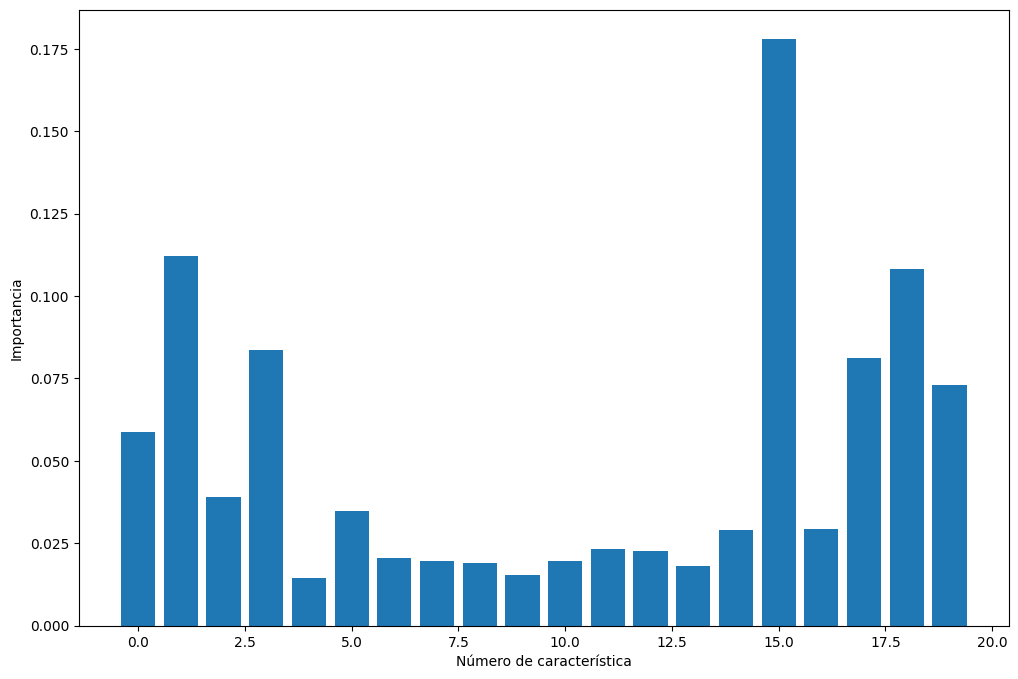

In [13]:
# Seleccion de características con random forest
from sklearn.ensemble import RandomForestClassifier

# Preparar los datos
y = df['Attraction'].copy()

# Crear el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf.fit(X_scaled, y)
# Extraer las importancias de las características
importances = rf.feature_importances_

# Graficar las importancias de las características
plt.figure(figsize=(12, 8))
plt.bar(range(len(importances)), importances)
plt.xlabel('Número de característica')
plt.ylabel('Importancia')
plt.show()

**Seleccionamos las 15 mejores caracteristicas**

In [14]:
df_vector_important_features = df_vector.iloc[:, importances.argsort()[::-1][:5]]

# Mostrar el dataframe
df_vector_important_features.head()

,V15,V1,V18,V3,V17
0,0.622609,0.251480,-1.230183,1.162277,1.665942
1,0.795250,-4.776636,-0.514808,-1.624254,-2.494186
2,0.480885,-1.352988,-2.592032,-2.508907,-0.803038
3,0.757071,-3.395986,-1.191843,-1.736962,0.595144
4,0.008123,1.836640,-0.357585,-1.585827,1.890342


**Entrenar el modelo con esta configuracion de caracteristicas**

In [15]:
# Prepapar los datos
X_best = df_vector_important_features

# Crear el modelo
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Entrenar el modelo
kmeans.fit(X_best)

KMeans(n_clusters=3, n_init=10, random_state=42)

**Evaluar resultados**

In [16]:
ymeans_best = kmeans.labels_

print("El índice de silueta es: ", silhouette_score(X_best, ymeans_best))
print("La puntuación de Calinski-Harabasz es: ", calinski_harabasz_score(X_best, ymeans_best))

El índice de silueta es:  0.18640913
La puntuación de Calinski-Harabasz es:  6991.759851433706


**Graficar**

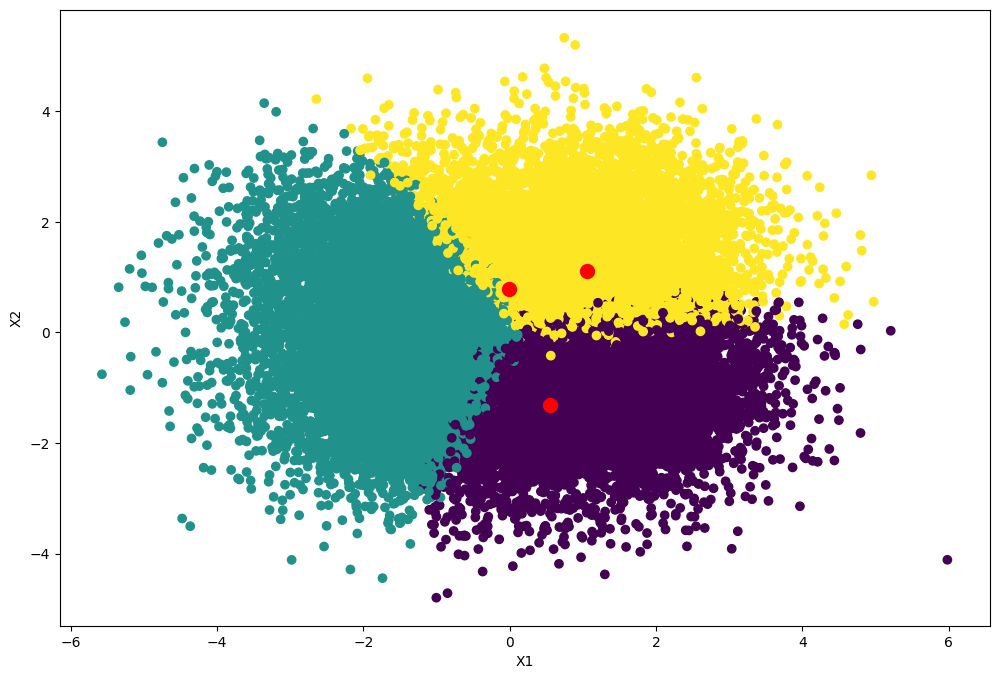

In [17]:
from sklearn.decomposition import PCA

# Crear el modelo
pca = PCA(n_components=2)

# Entrenar el modelo
pca.fit(X_best)

# Transformar los datos
X_pca_best = pca.transform(X_best)

# Graficar los clusters con centroides
plt.figure(figsize=(12, 8))
plt.scatter(X_pca_best[:, 0], X_pca_best[:, 1], c=ymeans_best, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()